In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from itertools import cycle
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from scikitplot.estimators import plot_learning_curve

from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
models = ['A', 'B', 'C', 'D']
for i in models:
    df = pd.concat([df, pd.read_csv('df_model%s_red.csv'%(i)).drop(columns = 'Unnamed: 0')], ignore_index=True) 

In [3]:
df_bin = df.copy()
df_bin.labels = df.labels.replace([2, 3, 4], 1)

In [4]:
labels_bin = df_bin.labels

In [5]:
features = df.iloc[:, :-2]
labels = df.labels

In [6]:
features

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,lead_ntrk,sub_ntrk
0,1143.592529,0.039967,146.150787,0.525687,0.505117,38,48,-27.057099,-23.003627
1,1476.433716,1.387635,14.246826,-1.370057,0.113648,21,33,-47.325838,-42.513492
2,1540.057007,1.520813,94.611481,1.142746,-0.478356,46,31,-22.852907,-45.262825
3,1533.117432,1.955224,79.998779,-0.021801,1.994529,46,37,-22.796860,-39.182772
4,1164.201416,0.747826,97.815399,-0.216873,0.608687,40,45,-25.285624,-26.312875
...,...,...,...,...,...,...,...,...,...
2067579,2686.224854,1.818661,211.678955,0.903337,-0.919513,58,129,-16.311280,44.333506
2067580,2692.715088,0.938040,136.215576,0.324722,-0.615071,78,78,3.673315,-6.691277
2067581,2476.301514,0.264742,106.248535,0.488685,0.740875,200,96,126.251694,12.251655
2067582,2140.740234,1.310556,192.544434,-0.370099,0.945993,134,99,61.481212,17.241032


In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
_, _, y_train_bin, y_test_bin = train_test_split(features, labels_bin, test_size=0.2, random_state=42)

In [8]:
x_test_control = x_test[(x_test.lead_ntrk < 0)]
x_test_control = x_test_control[(x_test_control.sub_ntrk < 0)]
x_train_control = x_train[(x_train.lead_ntrk < 0)]
x_train_control = x_train_control[(x_train_control.sub_ntrk < 0)]

y_test_control = y_test[x_test_control.index]
y_test_control_bin = y_test_bin[x_test_control.index]
y_train_control = y_train[x_train_control.index]
y_train_control_bin = y_train_bin[x_train_control.index]

In [9]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.iloc[:, :7])
x_test = scaler.fit_transform(x_test.iloc[:, :7])

x_train_control = scaler.fit_transform(x_train_control.iloc[:, :7])
x_test_control = scaler.fit_transform(x_test_control.iloc[:, :7])

# Multi-class

In [10]:
bkg = 0.
a = 0.
b = 0.
c = 0.
d = 0.
for i in y_train:
    if i == 0:
        bkg+=1
    elif i == 1:
        a+=1
    elif i == 2:
        b+=1
    elif i == 3:
        c+=1
    elif i == 4:
        d+=1

In [16]:
priors = np.array([bkg, a, b, c, d])/len(y_train)

In [17]:
nbc = GaussianNB(priors=priors)

In [18]:
nbc.fit(x_train_control, y_train_control)

GaussianNB(priors=array([0.50012243, 0.12493871, 0.12478999, 0.12502698, 0.1251219 ]))

In [14]:
pkl.dump(nbc, open('gaussian_bayes_red_control.pkl', 'wb'))

In [15]:
y_preds = nbc.predict(x_test_control)
precision = precision_score(y_test_control, y_preds, average='weighted')
recall = recall_score(y_test_control, y_preds, average = 'weighted')
f1 = f1_score(y_test_control, y_preds, average = 'weighted')
accuracy = accuracy_score(y_test_control, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.755
Recall: 0.735
F1: 0.729
Accuracy: 0.735


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

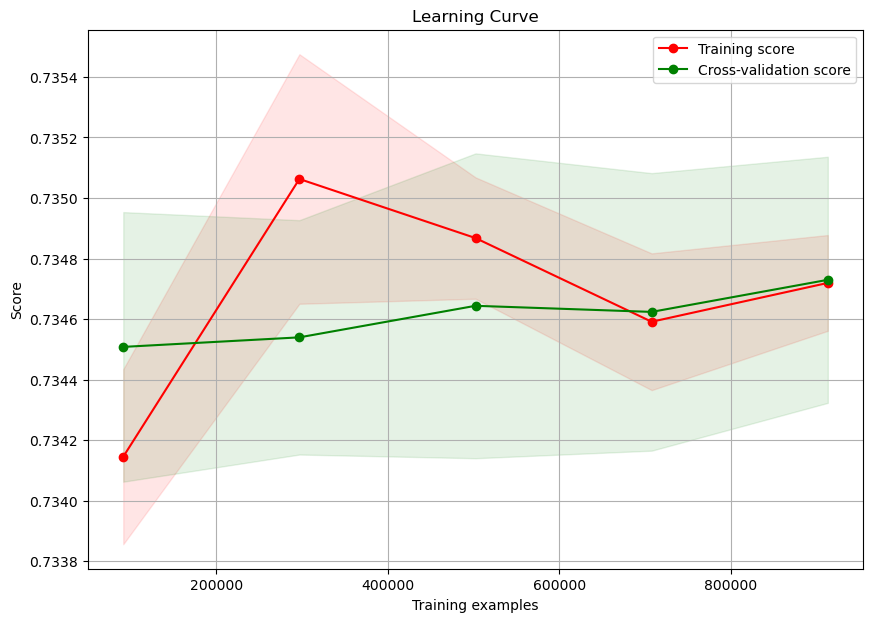

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(nbc, X = x_train_control, y = y_train_control, ax=ax)

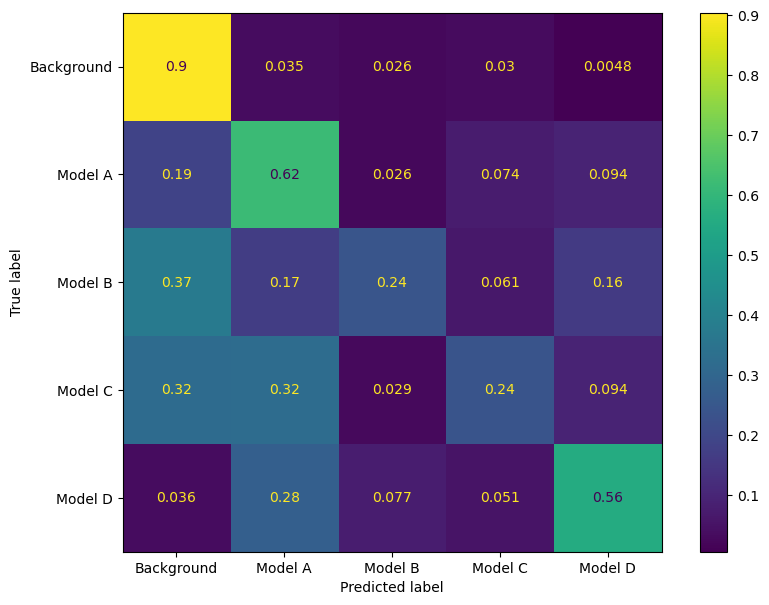

In [17]:
cm = confusion_matrix(y_test_control.values, y_preds, normalize='true')
tick_labs = ['Background', 'Model A', 'Model B', 'Model C', 'Model D']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Binary

In [21]:
bkg = 0.
sig = 0.
for i in y_train_control_bin:
    if i == 0:
        bkg+=1
    else:
        sig+=1

In [22]:
priors_binary = [bkg/len(y_train_control_bin), sig/len(y_train_control_bin)]

In [23]:
nbc_bin = GaussianNB(priors=priors_binary)
nbc_bin.fit(x_train_control, y_train_control_bin)

GaussianNB(priors=[0.7137425512194011, 0.2862574487805989])

In [24]:
pkl.dump(nbc_bin, open('gauss_bayes_bin_red_control.pkl', 'wb'))

In [25]:
y_preds = nbc_bin.predict(x_test_control)
precision = precision_score(y_test_control_bin, y_preds)
recall = recall_score(y_test_control_bin, y_preds)
f1 = f1_score(y_test_control_bin, y_preds)
accuracy = accuracy_score(y_test_control_bin, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.772
Recall: 0.667
F1: 0.716
Accuracy: 0.848


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

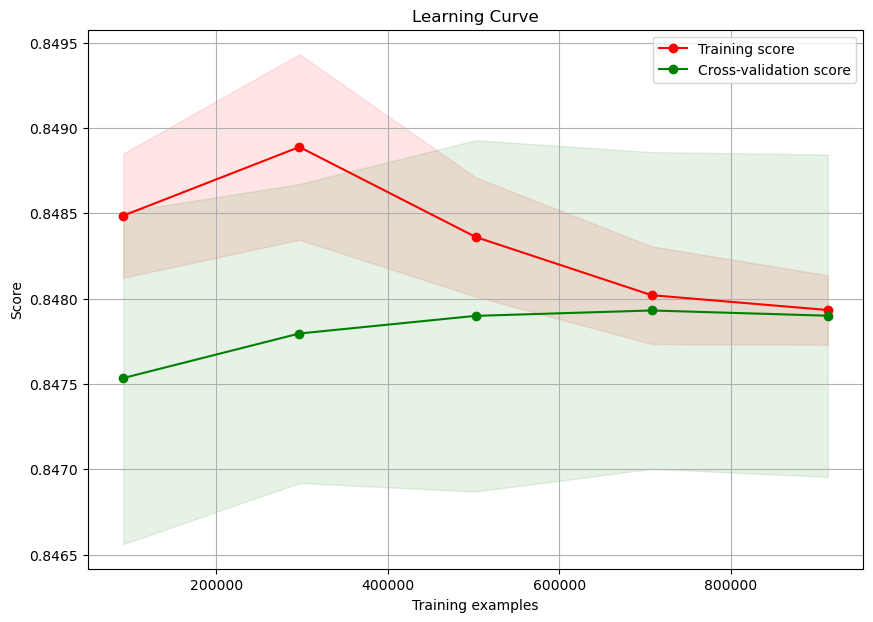

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(nbc_bin, X = x_train_control, y = y_train_control_bin, ax=ax)

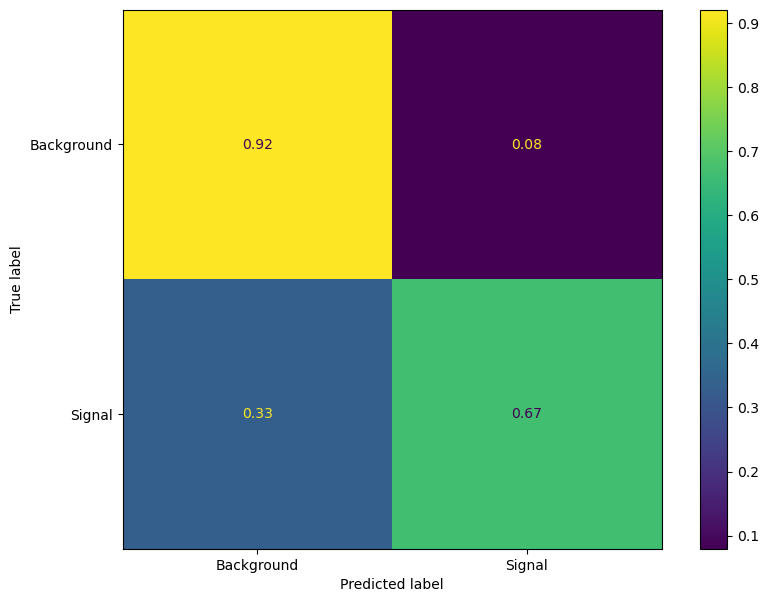

In [27]:
cm = confusion_matrix(y_test_control_bin.values, y_preds, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Scores

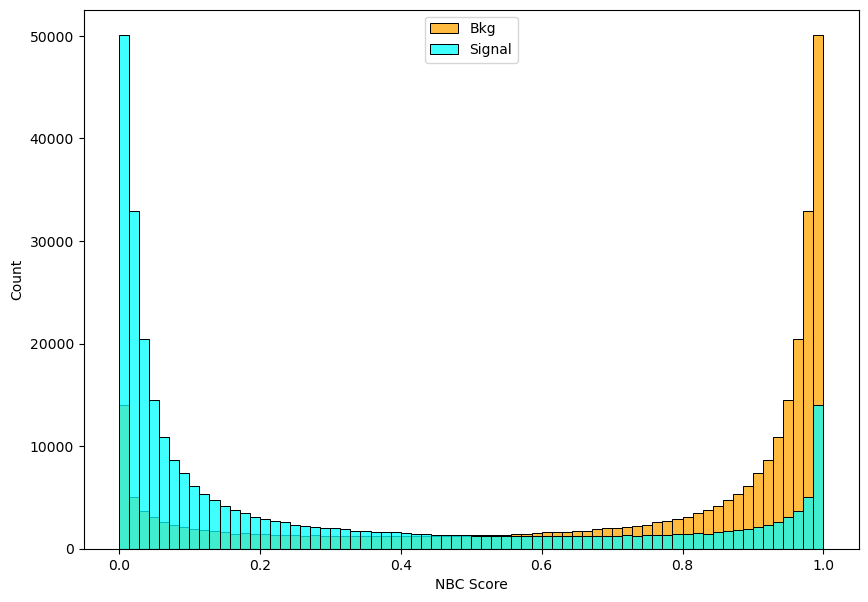

In [28]:
probs = nbc_bin.predict_proba(x_test_control)
preds = probs[:, 1]

scaled = MinMaxScaler().fit_transform(probs)
plt.figure(figsize=(10,7))
sns.histplot(x=scaled[:,0], color='orange', label = 'Bkg', bins=100)
sns.histplot(x=scaled[:,1], color='cyan', label = 'Signal', bins=100)
plt.xlabel('NBC Score')
plt.legend()
plt.show()

[2, 3, 4]
[5.86875025e-04 1.50703373e-02 8.71886198e-01 ... 3.69811648e-03
 1.46114909e-05 6.21085400e-04]


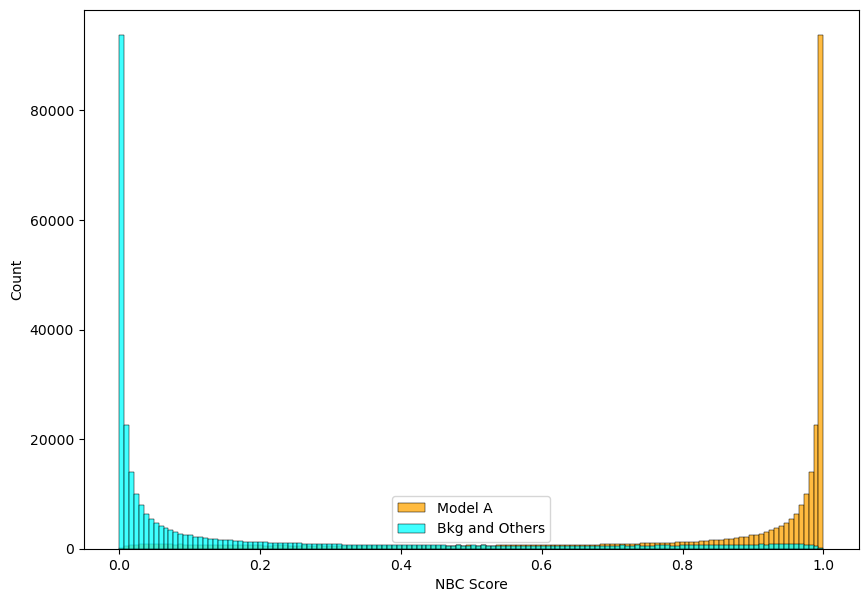

[1, 3, 4]
[0.10263023 0.05385267 0.69268942 ... 0.0386477  0.39332583 0.99769666]


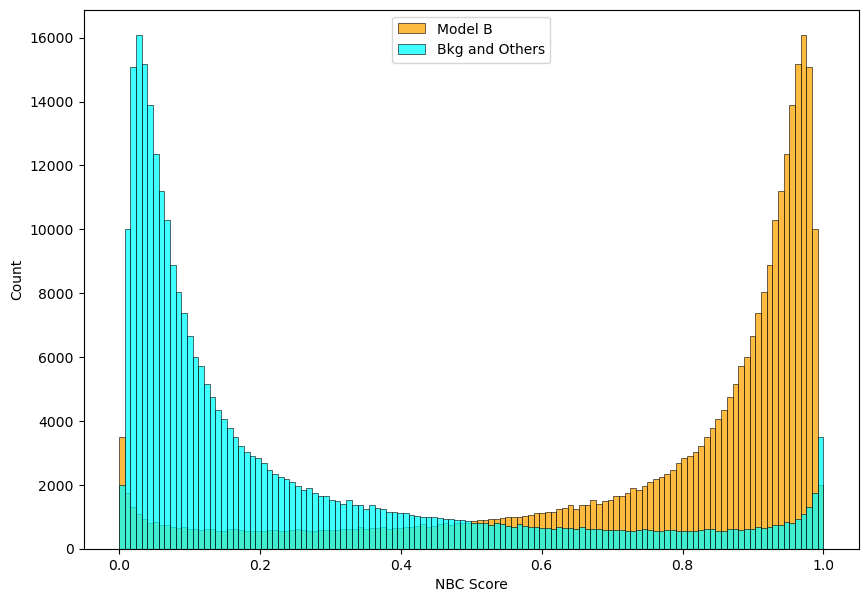

[1, 2, 4]
[1.39883850e-03 4.96191717e-02 6.86682864e-01 ... 2.07413257e-02
 5.38296882e-05 9.99999250e-01]


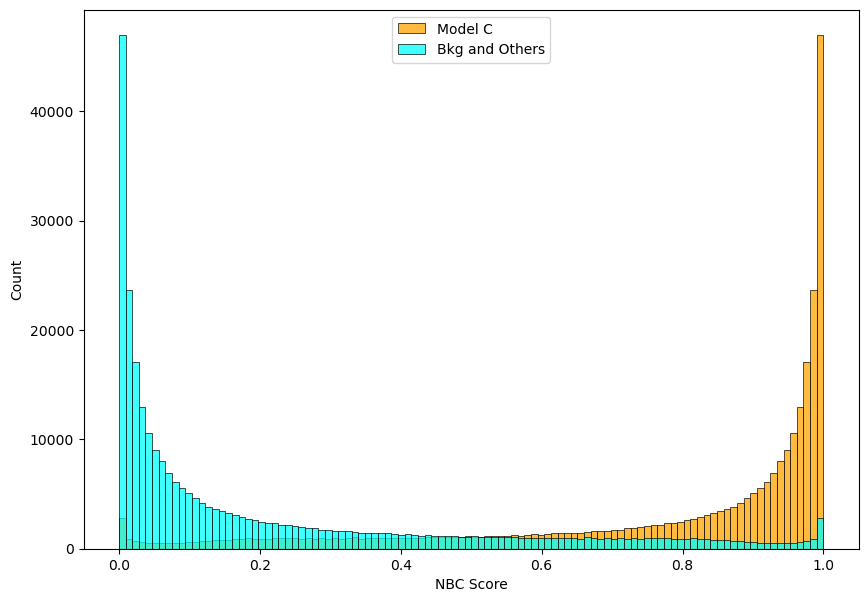

[1, 2, 3]
[1.15598250e-03 9.16727856e-04 6.77952994e-01 ... 2.14628022e-04
 1.38315997e-03 9.99966491e-01]


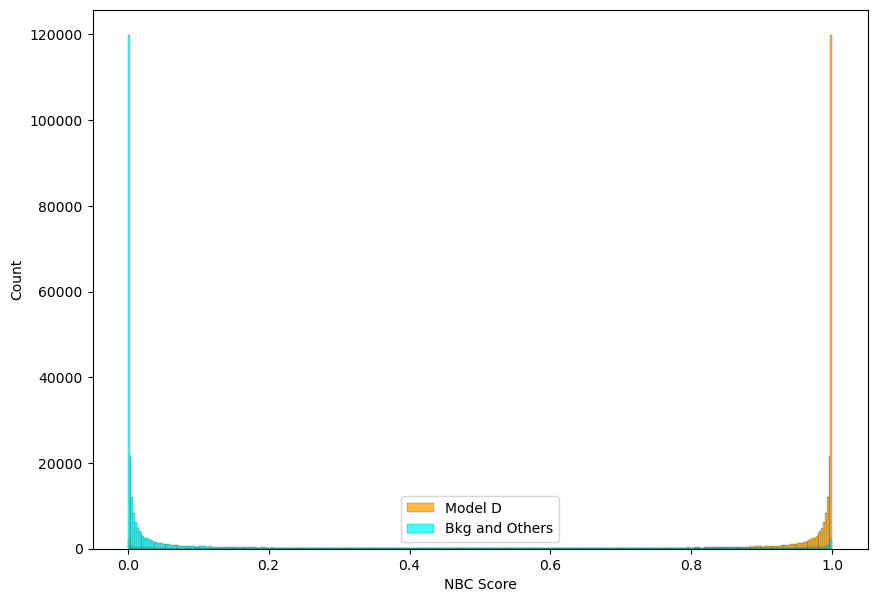

In [30]:
classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    #y_test_new = y_test.replace(to_replace=new, value=0)
    #y_test_new = y_test_new.replace(i, 1)
    y_train_new = y_train_control.replace(to_replace = new, value = 0)
    y_train_new = y_train_new.replace(i, 1)
    nbc_bin.fit(x_train_control, y_train_new)
    probs = nbc_bin.predict_proba(x_test_control)
    preds = probs[:, 1]
    print(preds)
    scaled = MinMaxScaler().fit_transform(probs)
    plt.figure(figsize=(10,7))
    sns.histplot(x=scaled[:,0], color='orange', label = 'Model %s'%models[i], bins=100)
    sns.histplot(x=scaled[:,1], color='cyan', label = 'Bkg and Others', bins=100)
    plt.xlabel('NBC Score')
    plt.legend()
    plt.show()

# ROC Curves

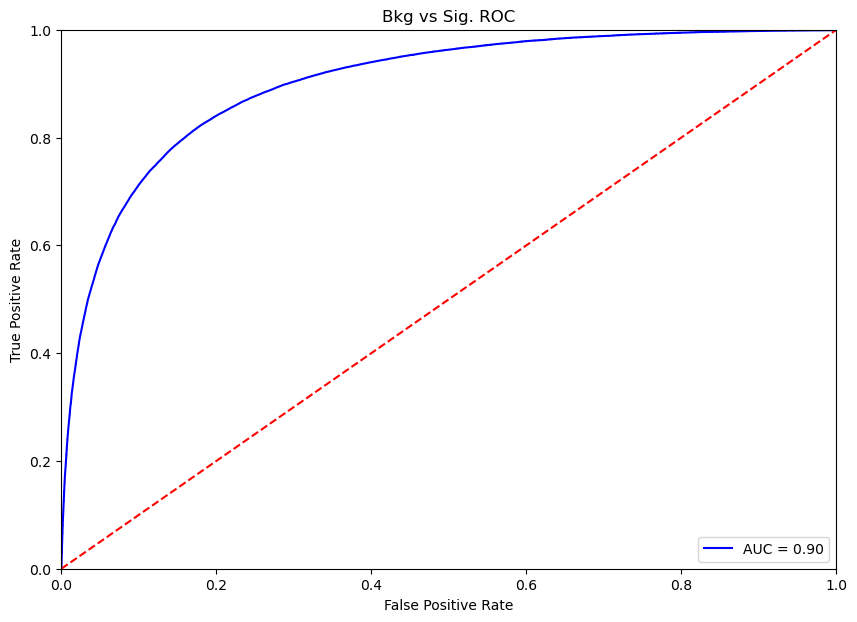

In [31]:
probs = nbc_bin.predict_proba(x_test_control)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test_control_bin, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [32]:
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test_control.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    probs = nbc.predict_proba(x_test_control)
    preds = probs[:, 1]
    fp, tp, thresh = roc_curve(y_test_new, preds)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

[2, 3, 4]
[1, 3, 4]
[1, 2, 4]
[1, 2, 3]


Model A optimum classification threshold: 0.115
Model B optimum classification threshold: 0.023
Model C optimum classification threshold: 0.032
Model D optimum classification threshold: 0.112


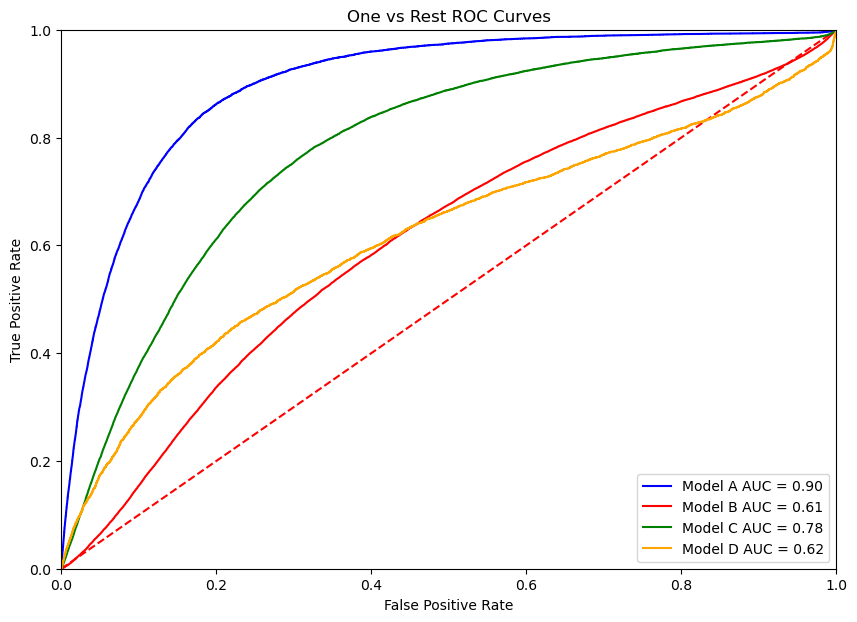

In [33]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('One vs Rest ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.show()

# train on pre, test on control

In [12]:
nbc = pkl.load(open('gaussian_bayes_red.pkl', 'rb'))
nbc_bin = pkl.load(open('gaussian_bayes_bin_red.pkl', 'rb'))

# Multi

In [72]:
y_preds = nbc.predict(x_test_control)
precision = precision_score(y_test_control, y_preds, average='weighted')
recall = recall_score(y_test_control, y_preds, average = 'weighted')
f1 = f1_score(y_test_control, y_preds, average = 'weighted')
accuracy = accuracy_score(y_test_control, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.644
Recall: 0.682
F1: 0.650
Accuracy: 0.682


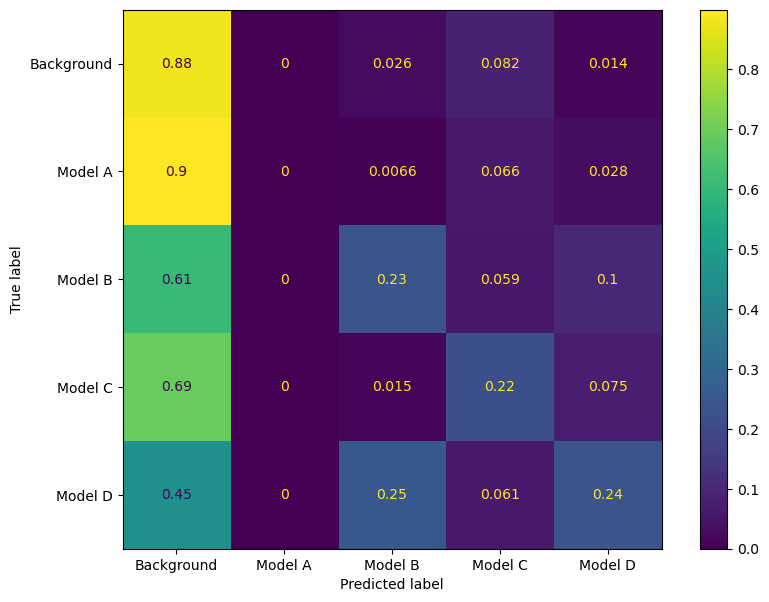

In [73]:
cm = confusion_matrix(y_test_control.values, y_preds, normalize='true')
tick_labs = ['Background', 'Model A', 'Model B', 'Model C', 'Model D']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Without ungroomed

In [68]:
y_preds = nbc.predict(x_test)
precision = precision_score(y_test, y_preds, average='weighted')
recall = recall_score(y_test, y_preds, average = 'weighted')
f1 = f1_score(y_test, y_preds, average = 'weighted')
accuracy = accuracy_score(y_test, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.424
Recall: 0.520
F1: 0.448
Accuracy: 0.520


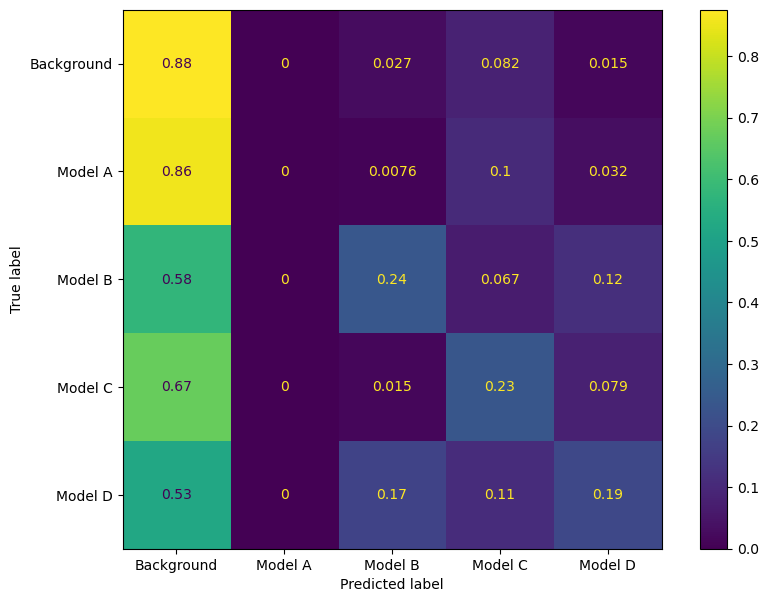

In [69]:
cm = confusion_matrix(y_test.values, y_preds, normalize='true')
tick_labs = ['Background', 'Model A', 'Model B', 'Model C', 'Model D']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Binary

In [74]:
y_preds = nbc_bin.predict(x_test_control)
precision = precision_score(y_test_control_bin, y_preds)
recall = recall_score(y_test_control_bin, y_preds)
f1 = f1_score(y_test_control_bin, y_preds)
accuracy = accuracy_score(y_test_control_bin, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.515
Recall: 0.514
F1: 0.514
Accuracy: 0.721


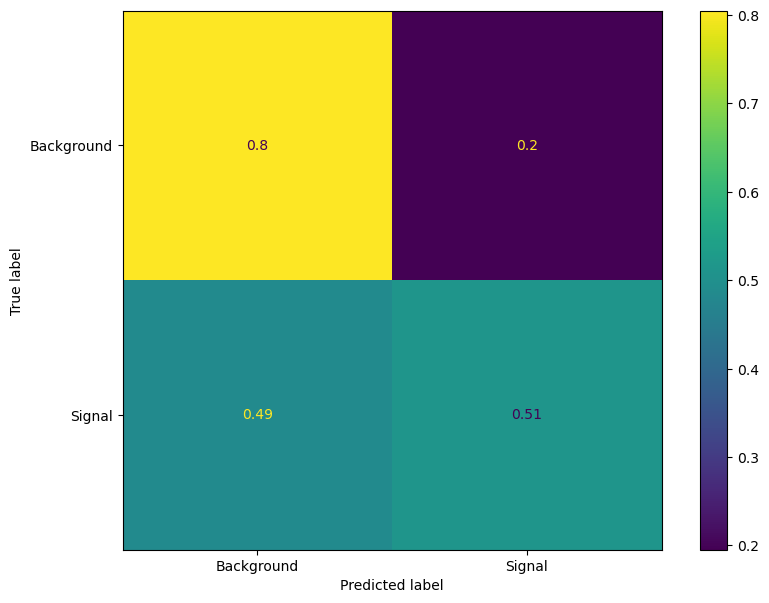

In [75]:
cm = confusion_matrix(y_test_control_bin.values, y_preds, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Without ungroomed

In [70]:
y_preds = nbc_bin.predict(x_test)
precision = precision_score(y_test_bin, y_preds)
recall = recall_score(y_test_bin, y_preds)
f1 = f1_score(y_test_bin, y_preds)
accuracy = accuracy_score(y_test_bin, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

Precision: 0.726
Recall: 0.535
F1: 0.616
Accuracy: 0.666


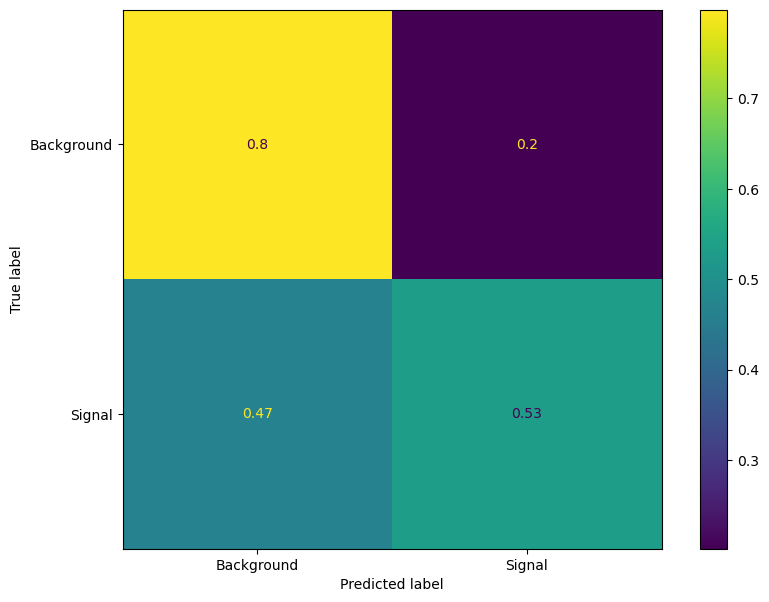

In [71]:
cm = confusion_matrix(y_test_bin.values, y_preds, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize = (10, 7))
cm_display.plot(ax=ax)
plt.show()

# Scores

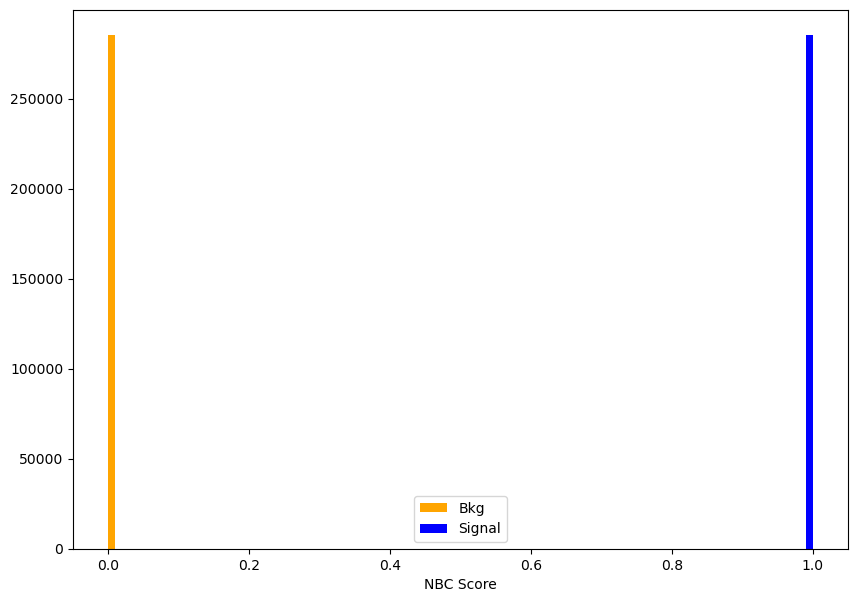

In [15]:
probs = nbc_bin.predict_proba(x_test_control)
preds = probs[:, 1]

scaled = MinMaxScaler().fit_transform(probs)
plt.figure(figsize=(10,7))
plt.hist(x=scaled[:,0], color='orange', label = 'Bkg', bins=100)
plt.hist(x=scaled[:,1], color='blue', label = 'Signal', bins=100)
plt.xlabel('NBC Score')
plt.legend()
plt.savefig('plots/fixed_scores/nbc_bin_scores_control_test.png')
plt.show()

classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    #y_test_new = y_test.replace(to_replace=new, value=0)
    #y_test_new = y_test_new.replace(i, 1)
    y_train_new = y_train_control.replace(to_replace = new, value = 0)
    y_train_new = y_train_new.replace(i, 1)
    nbc_bin.fit(x_train_control, y_train_new)
    probs = nbc_bin.predict_proba(x_test_control)
    preds = probs[:, 1]
    print(preds)
    scaled = MinMaxScaler().fit_transform(probs)
    plt.figure(figsize=(10,7))
    sns.histplot(x=scaled[:,0], color='orange', label = 'Model %s'%models[i], bins =100)
    sns.histplot(x=scaled[:,1], color='cyan', label = 'Bkg and Others', bins=100)
    plt.xlabel('NBC Score')
    plt.legend()
    plt.show()

1


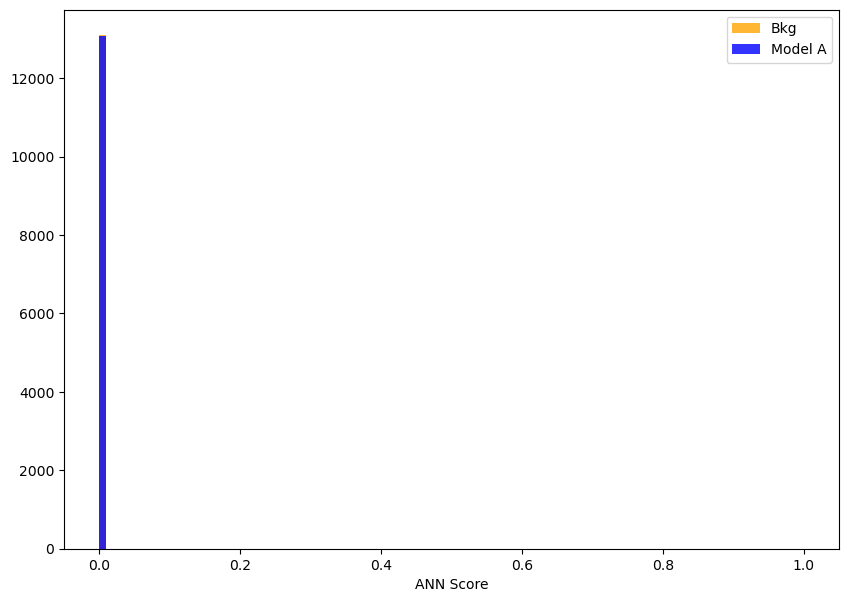

2


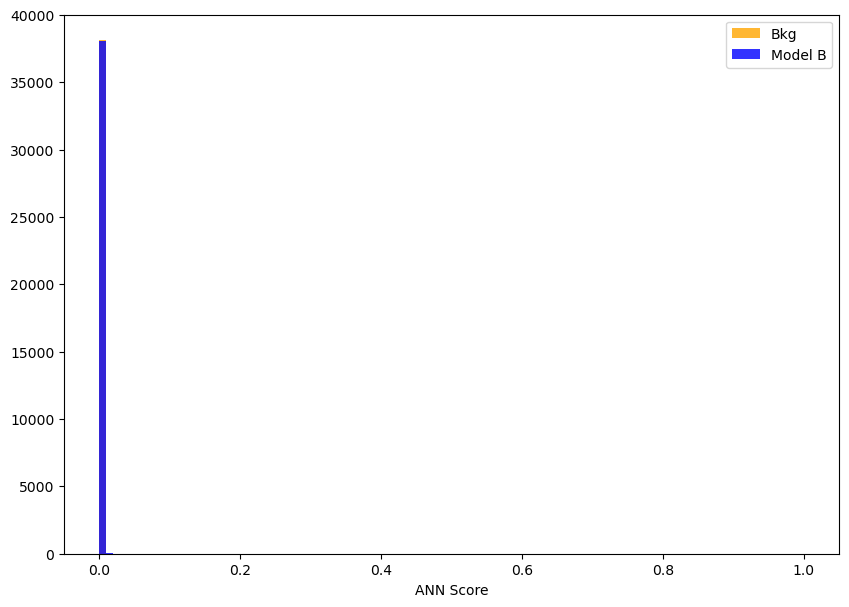

3


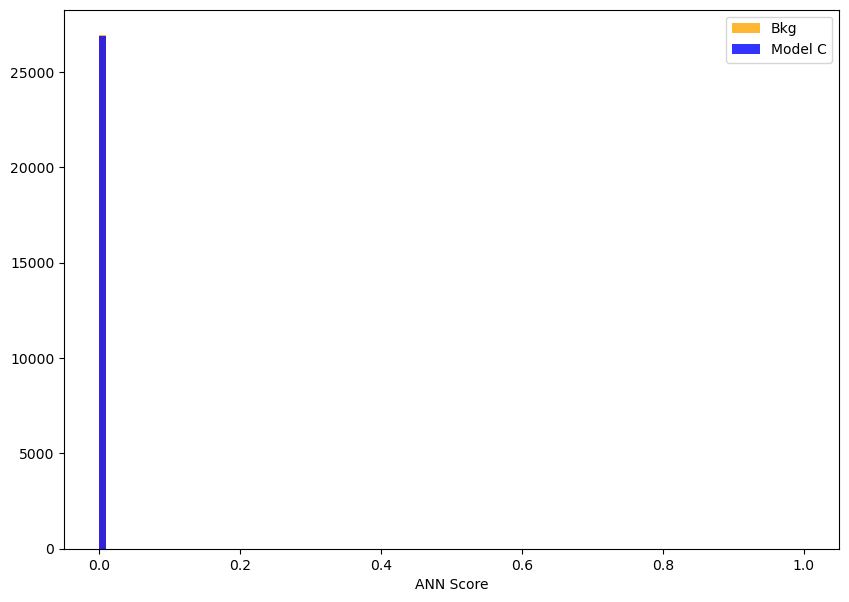

4


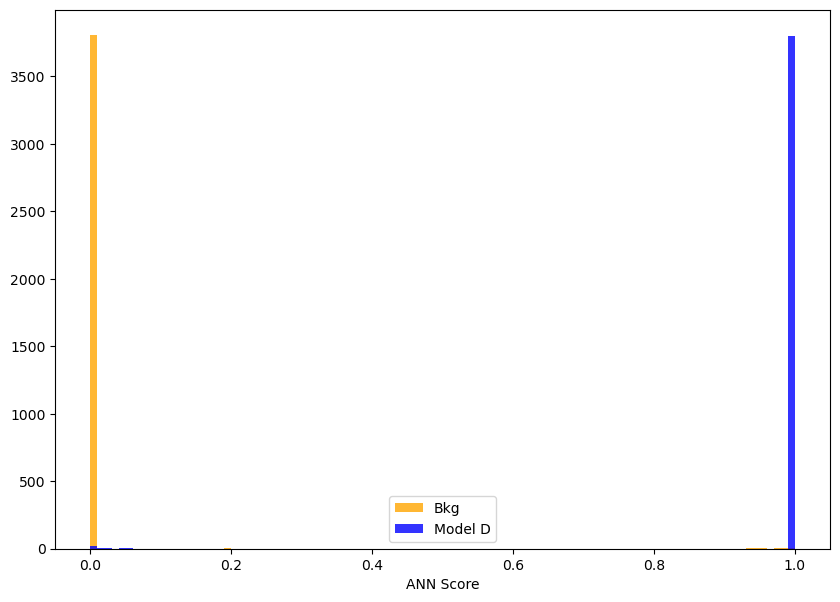

In [16]:
classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    print(i)
    test = np.array([x_test_control[j] for j in range(len(y_test_control)) if y_test_control.values[j] == i])
    probs = nbc.predict_proba(test)
    
    scaled = MinMaxScaler().fit_transform(probs)
    plt.figure(figsize=(10,7))
    plt.hist(x=scaled[::,0], color='orange', label = 'Bkg', alpha = 0.8, bins = 100)
    plt.hist(x=scaled[::,i], color='blue', label = 'Model %s'%models[i], alpha = 0.8, bins = 100)
    plt.xlabel('ANN Score')
    plt.legend()
    plt.savefig('plots/fixed_scores/nbc_bkg_vs_model%s_scores_control_test.png'%models[i])
    plt.show()

# ROC Curves

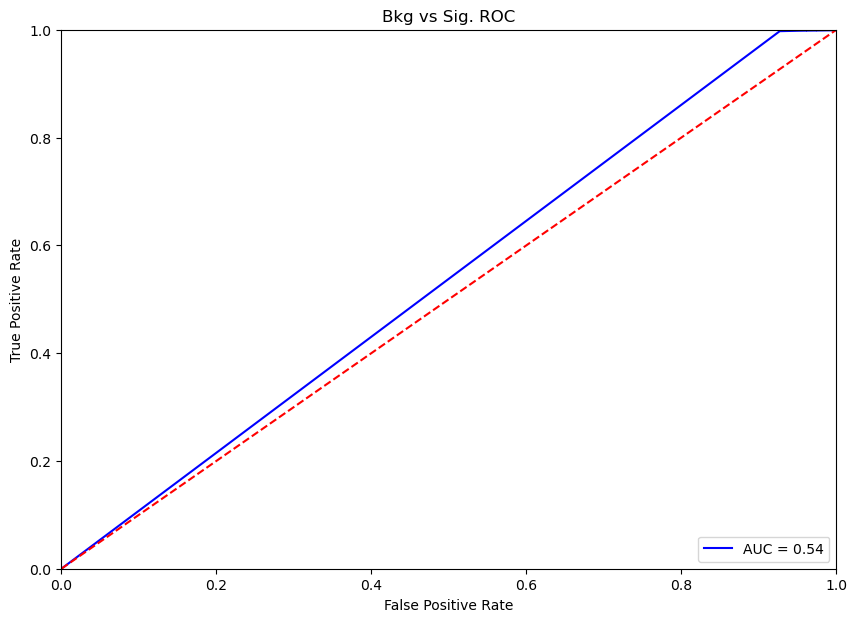

In [17]:
probs = nbc_bin.predict_proba(x_test_control)
preds = probs[::, 1]
fpr, tpr, threshold = roc_curve(y_test_control_bin, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('plots/fixed_rocs/nbc_bin_roc_control_test.png')
plt.show()

classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test_control.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    probs = nbc.predict_proba(x_test_control)
    preds = probs[:, 1]
    fp, tp, thresh = roc_curve(y_test_new, preds)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

In [18]:
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    x_test_new = np.array([x_test_control[j] for j in range(len(y_test_control)) if (y_test_control.values[j] == i) or (y_test_control.values[j] == 0)])
    y_test_new = [k for k in y_test_control.values if (k==i) or (k==0)]
    probs = nbc.predict_proba(x_test_new)
    preds = probs[:, i]
    fp, tp, thresh = roc_curve(y_test_new, preds, pos_label=i)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

Model A optimum classification threshold: 1.826
Model B optimum classification threshold: 0.940
Model C optimum classification threshold: 0.861
Model D optimum classification threshold: 1.000


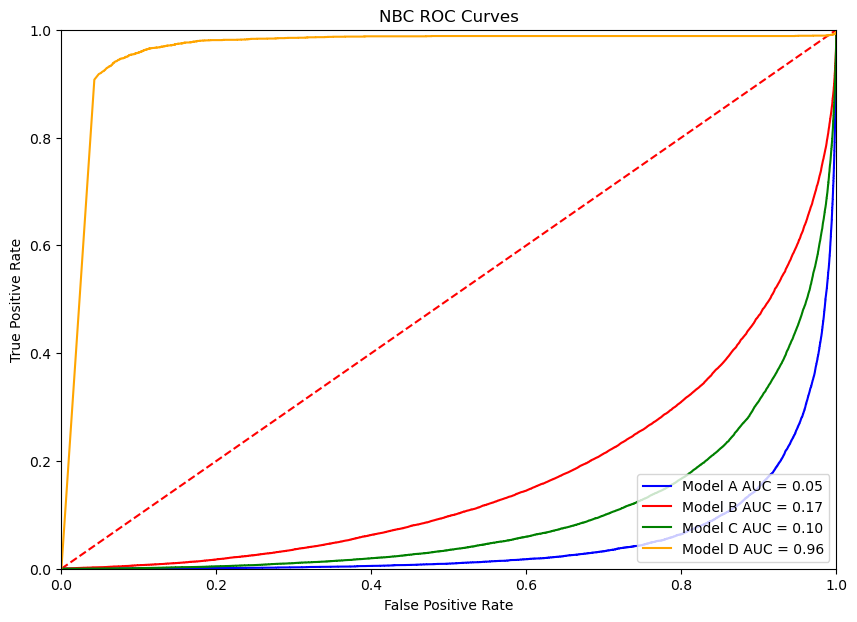

In [19]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('NBC ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.savefig('plots/fixed_rocs/nbc_roc_control_test.png')
plt.show()